In [2]:

import nomic
import json

#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm
from graspologic.embed import ClassicalMDS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz



In [10]:
df_vote_result=pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Twitters/congressional-twin/data/data/118-2024_h142.csv')
#df_vote_result.drop('', axis=1, inplace=True)
df_vote_result.dropna(inplace=True) 
vote_str = '118-2024_h142'
df_vote_result.head()

,Unnamed: 0,person,state,district,vote,name,party,matched-name,twitter-handle,average-embd-global,average-embd-issue-specific,matched-state,matched-party
0,0,400004,AL,4,Yea,Rep. Robert Aderholt [R],Republican,"Aderholt, Robert",robert_aderholt,"[0.017503820146833146, 0.03896857670375279, -0...","[0.006040811538696289, 0.042439937591552734, -...",AL,R
1,1,400030,GA,2,Not Voting,Rep. Sanford Bishop [D],Democrat,"Bishop Jr., Sanford",sanfordbishop,"[0.018433302640914917, 0.049648284912109375, -...","[0.017269134521484375, 0.0095062255859375, -0....",GA,D
3,3,400052,TX,26,Yea,Rep. Michael Burgess [R],Republican,"Burgess, Michael",michaelcburgess,"[0.021851594874400967, 0.05065598708904342, -0...","[0.02545155649599822, 0.08420595915421196, -0....",TX,R
4,4,400057,CA,41,Yea,Rep. Ken Calvert [R],Republican,"Calvert, Ken",kencalvert,"[0.018314135260879993, 0.05678512156009674, -0...","[0.020268772777758147, 0.06673792788856908, -0...",CA,R
5,5,400068,TX,31,Yea,Rep. John R. Carter [R],Republican,"Carter, John",judgecarter,"[0.02061185469994178, 0.0426945319542518, -0.1...","[0.030901227678571428, 0.078216552734375, -0.1...",TX,R


In [11]:
average_embd_global = np.array([eval(d) for d in df_vote_result['average-embd-global'].values])
average_embd_issue_specific = np.array([eval(d) for d in df_vote_result['average-embd-issue-specific'].values])

vote = [v for v in df_vote_result['vote'].values]
party = [p for p in df_vote_result['matched-party'].values]

vote_inds = []
y = []
for i, v in enumerate(vote):
    if v.lower() == 'nay':
        y.append(0)
    elif v.lower() == 'yea':
        y.append(1)
    else:
        continue
    vote_inds.append(i)    
vote_inds = np.array(vote_inds) ## exclude the not voting 


Text(0.5, 1.0, 'CMDS global // by vote')

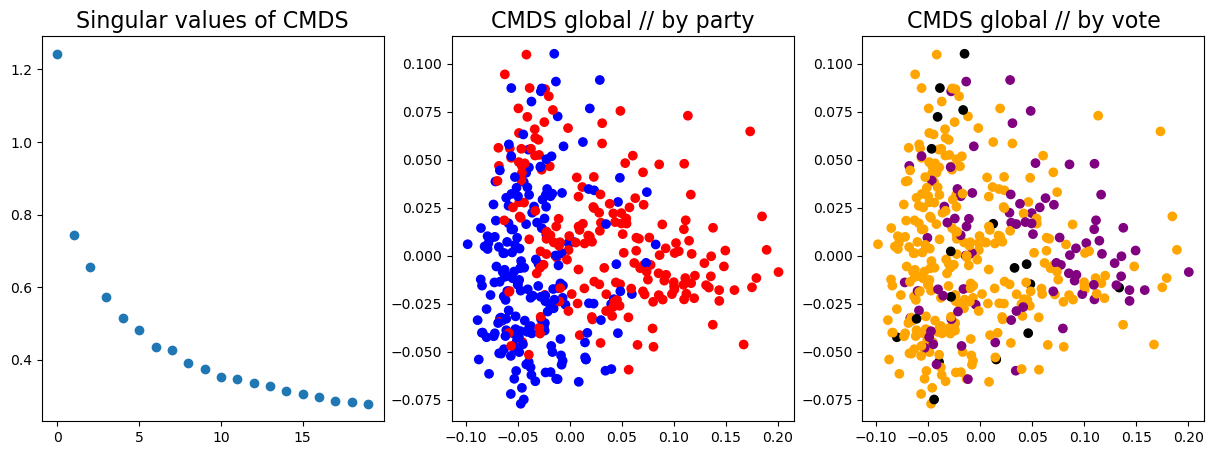

In [12]:
## visual analysis

cmds = ClassicalMDS(n_components=20)
_ = cmds.fit_transform(average_embd_global)
svs = cmds.singular_values_

cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd_global)

vote_colors = {
    'yea': 'orange',
    'nay': 'purple',
    'not voting': 'black'
}

party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
}

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(range(len(svs)), svs)
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[party_colors[p.lower()] for p in party])
ax[2].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[vote_colors[v.lower()] for v in vote])

ax[0].set_title('Singular values of CMDS', fontsize=16)
ax[1].set_title('CMDS global // by party', fontsize=16)
ax[2].set_title('CMDS global // by vote', fontsize=16)

Text(0.5, 1.0, 'CMDS issue specific // by vote')

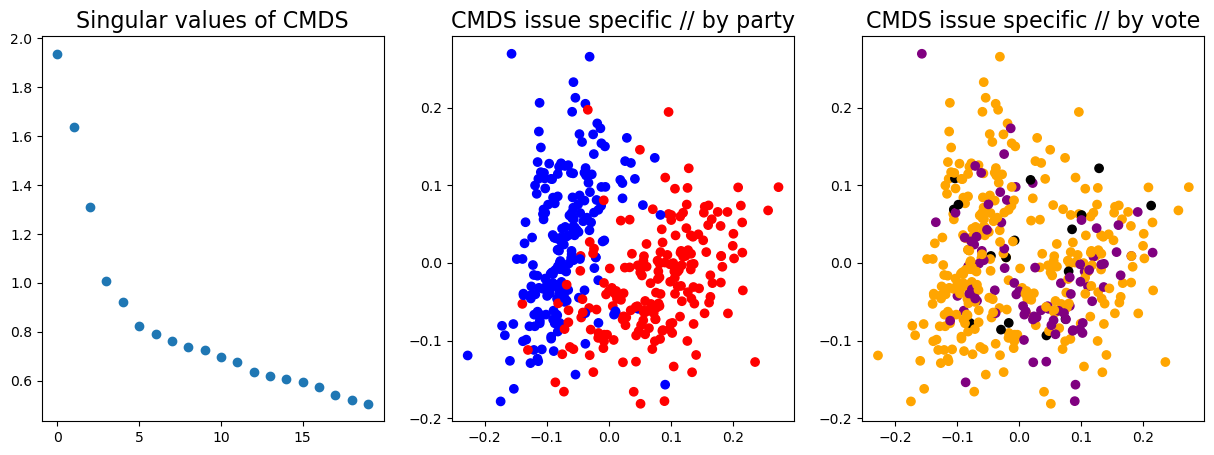

In [13]:
cmds = ClassicalMDS(n_components=20)
_ = cmds.fit_transform(average_embd_issue_specific)
svs = cmds.singular_values_

cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd_issue_specific)

vote_colors = {
    'yea': 'orange',
    'nay': 'purple',
    'not voting': 'black'
}

party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
}

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(range(len(svs)), svs)
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[party_colors[p.lower()] for p in party])
ax[2].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[vote_colors[v.lower()] for v in vote])

ax[0].set_title('Singular values of CMDS', fontsize=16)
ax[1].set_title('CMDS issue specific // by party', fontsize=16)
ax[2].set_title('CMDS issue specific // by vote', fontsize=16)

In [14]:
cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd_global)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas
import matplotlib.pyplot as plt
import seaborn as sns

### 2D CMDS for predicting votes: issue_specific  average.e is much better than  global average 

In [16]:
cmds_embds = cmds.fit_transform(average_embd_global)
x = cmds_embds[vote_inds,:2]
vote_model = LogisticRegression()
vote_model.fit(x, y)
er = bas(y, vote_model.predict(x))
er


0.5

In [17]:
cmds_embds = cmds.fit_transform(average_embd_issue_specific)
x = cmds_embds[vote_inds,:2]
vote_model = LogisticRegression()
vote_model.fit(x, y)
er = bas(y, vote_model.predict(x))
er

0.5

## 1D cmds for predicting vote, still issue_specifc is better than global

Text(0.5, 1.02, 'Efficacy of average embedding+LogR \n for 118-2024_h142')

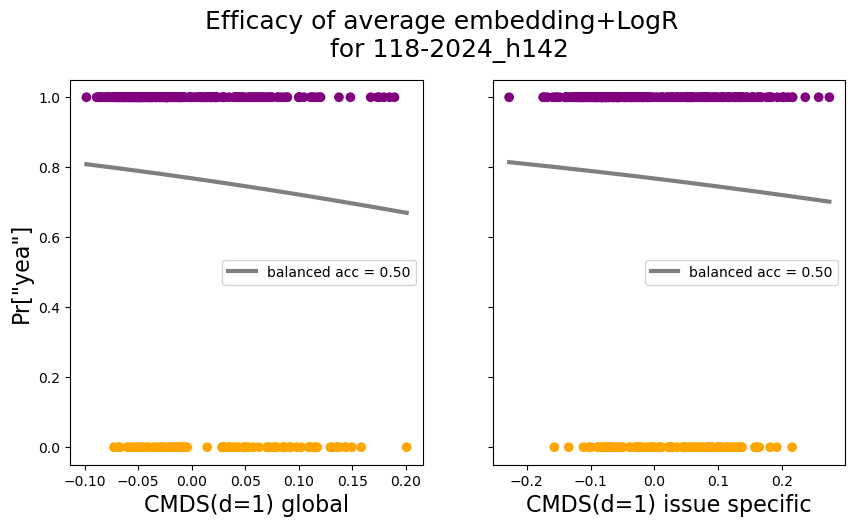

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

### global
cmds_embds = cmds.fit_transform(average_embd_global)
x = cmds_embds[vote_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1) global', fontsize=16)



###isuue specific
cmds_embds = cmds.fit_transform(average_embd_issue_specific)
x = cmds_embds[vote_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[1].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel('CMDS(d=1) issue specific', fontsize=16)


fig.suptitle(f'Efficacy of average embedding+LogR \n for {vote_str}', fontsize=18, y=1.02)



## LDA $\circ$ CMDS(d=20) with party label for predicting votes

Text(0.5, 0, 'Issue speicifc LDA(y=party) o CMDS(d=4)')

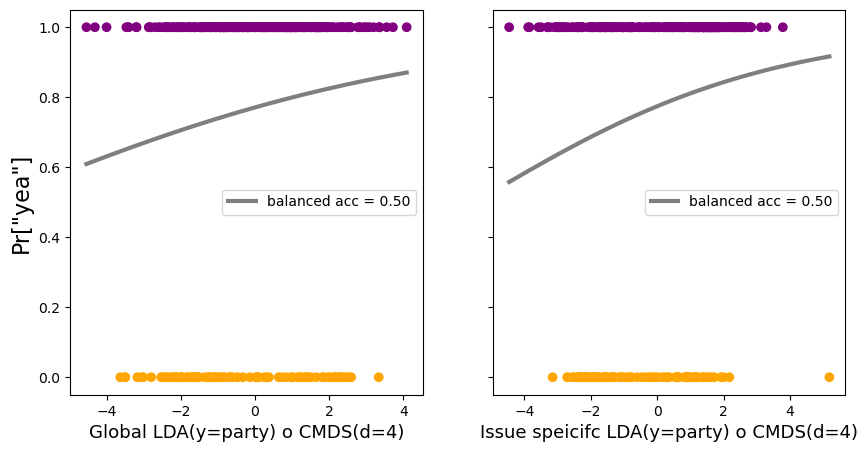

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

cmds = ClassicalMDS(n_components=4)
cmds_embds = cmds.fit_transform(average_embd_global)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])[:,:1]

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[0].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel(f'Global LDA(y=party) o CMDS(d={cmds_embds.shape[1]})', fontsize=13)


cmds = ClassicalMDS(n_components=4)
cmds_embds = cmds.fit_transform(average_embd_issue_specific)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])[:,:1]

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'Issue speicifc LDA(y=party) o CMDS(d={cmds_embds.shape[1]})', fontsize=13)




## some isomap try

In [24]:
from sklearn.manifold import Isomap

# Create an instance of Isomap with n_components=1
isomap = Isomap(n_components=10)

# Fit and transform the average_embd_issue_specific array
#x = isomap.fit_transform(average_embd_global)[vote_inds,:] 
x = isomap.fit_transform(average_embd_issue_specific)[vote_inds,:]  

#cmds_embds = cmds.fit_transform(average_embd_issue_specific)

x = cmds_embds[vote_inds,:300]


vote_model = LogisticRegression()
vote_model.fit(x, y)

bas(y, vote_model.predict(x))


0.5